In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import subprocess as sp
from tqdm.notebook import tqdm

## Individual Runtimes of Malloc, work, free

Make sure GPU MPI is built in release mode here (with -DCMAKE_BUILD_TYPE=Release).

In [9]:
def compile_benchmark(benchmark, malloc_version, mapping):
    cmd_res = sp.run("cd ../build && GPU_MPI_PROJECT=`pwd`/.. GPU_MPI_MAX_RANKS=2000000 python scripts/gpumpicc.py ../mpi_malloc_benchmarks/" + benchmark + ".c --malloc_version=" + str(malloc_version) + " -- -o " + benchmark + mapping[malloc_version], shell=True)
    cmd_res.check_returncode()

In [13]:
def get_mean_std_individual_workloads(n_blocks, n_threads_per_block, n_runs, n_doubles, workload):
    measurements = []
#     return ([0,0,0], [0,0,0])
    for _ in range(0, n_runs):
        cmd_res = sp.run("../build/" + workload + " " + str(n_doubles) + " ---gpumpi -g " + str(n_blocks) + " -b " + str(n_threads_per_block), shell=True, capture_output=True, text=True)
        cmd_res.check_returncode()
        measurements.append(cmd_res.stdout.split("\n")[:3])
    
    measurements = np.array(measurements).astype(float)

    mean = np.mean(measurements, axis=0)
    std = np.std(measurements, axis=0)
    
    return (mean, std)

** Creating AST consumer for: /home/merhart/dphpc-project/build/../mpi_malloc_benchmarks/alltoall.c
Trying to write /home/merhart/dphpc-project/build/../mpi_malloc_benchmarks/alltoall.c : /home/merhart/dphpc-project/mpi_malloc_benchmarks/alltoall.c
../mpi_malloc_benchmarks/alltoall.cu(17): warning #177-D: variable "prod" was declared but never referenced

../mpi_malloc_benchmarks/alltoall.cu(17): warning #177-D: variable "prod" was declared but never referenced

../mpi_malloc_benchmarks/alltoall.cu(17): warning #177-D: variable "prod" was declared but never referenced

nvlink warning : Stack size for entry function '_Z17__gpu_main_calleriPPcPN7CudaMPI11SharedStateENS1_18ThreadPrivateState7ContextE' cannot be statically determined (target: sm_60)
nvlink warning : Stack size for entry function '_Z17__gpu_main_calleriPPcPN7CudaMPI11SharedStateENS1_18ThreadPrivateState7ContextE' cannot be statically determined (target: sm_61)
nvlink warning : Stack size for entry function '_Z17__gpu_main_c

../mpi_malloc_benchmarks/bcast.cu(18): warning #177-D: variable "prod_x" was declared but never referenced

../mpi_malloc_benchmarks/bcast.cu(18): warning #177-D: variable "prod_y" was declared but never referenced

../mpi_malloc_benchmarks/bcast.cu(18): warning #177-D: variable "prod_x" was declared but never referenced

../mpi_malloc_benchmarks/bcast.cu(18): warning #177-D: variable "prod_y" was declared but never referenced

nvlink warning : Stack size for entry function '_Z17__gpu_main_calleriPPcPN7CudaMPI11SharedStateENS1_18ThreadPrivateState7ContextE' cannot be statically determined (target: sm_60)
nvlink warning : Stack size for entry function '_Z17__gpu_main_calleriPPcPN7CudaMPI11SharedStateENS1_18ThreadPrivateState7ContextE' cannot be statically determined (target: sm_61)
nvlink warning : Stack size for entry function '_Z17__gpu_main_calleriPPcPN7CudaMPI11SharedStateENS1_18ThreadPrivateState7ContextE' cannot be statically determined (target: sm_70)
** Creating AST consumer for

Compiling finished


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

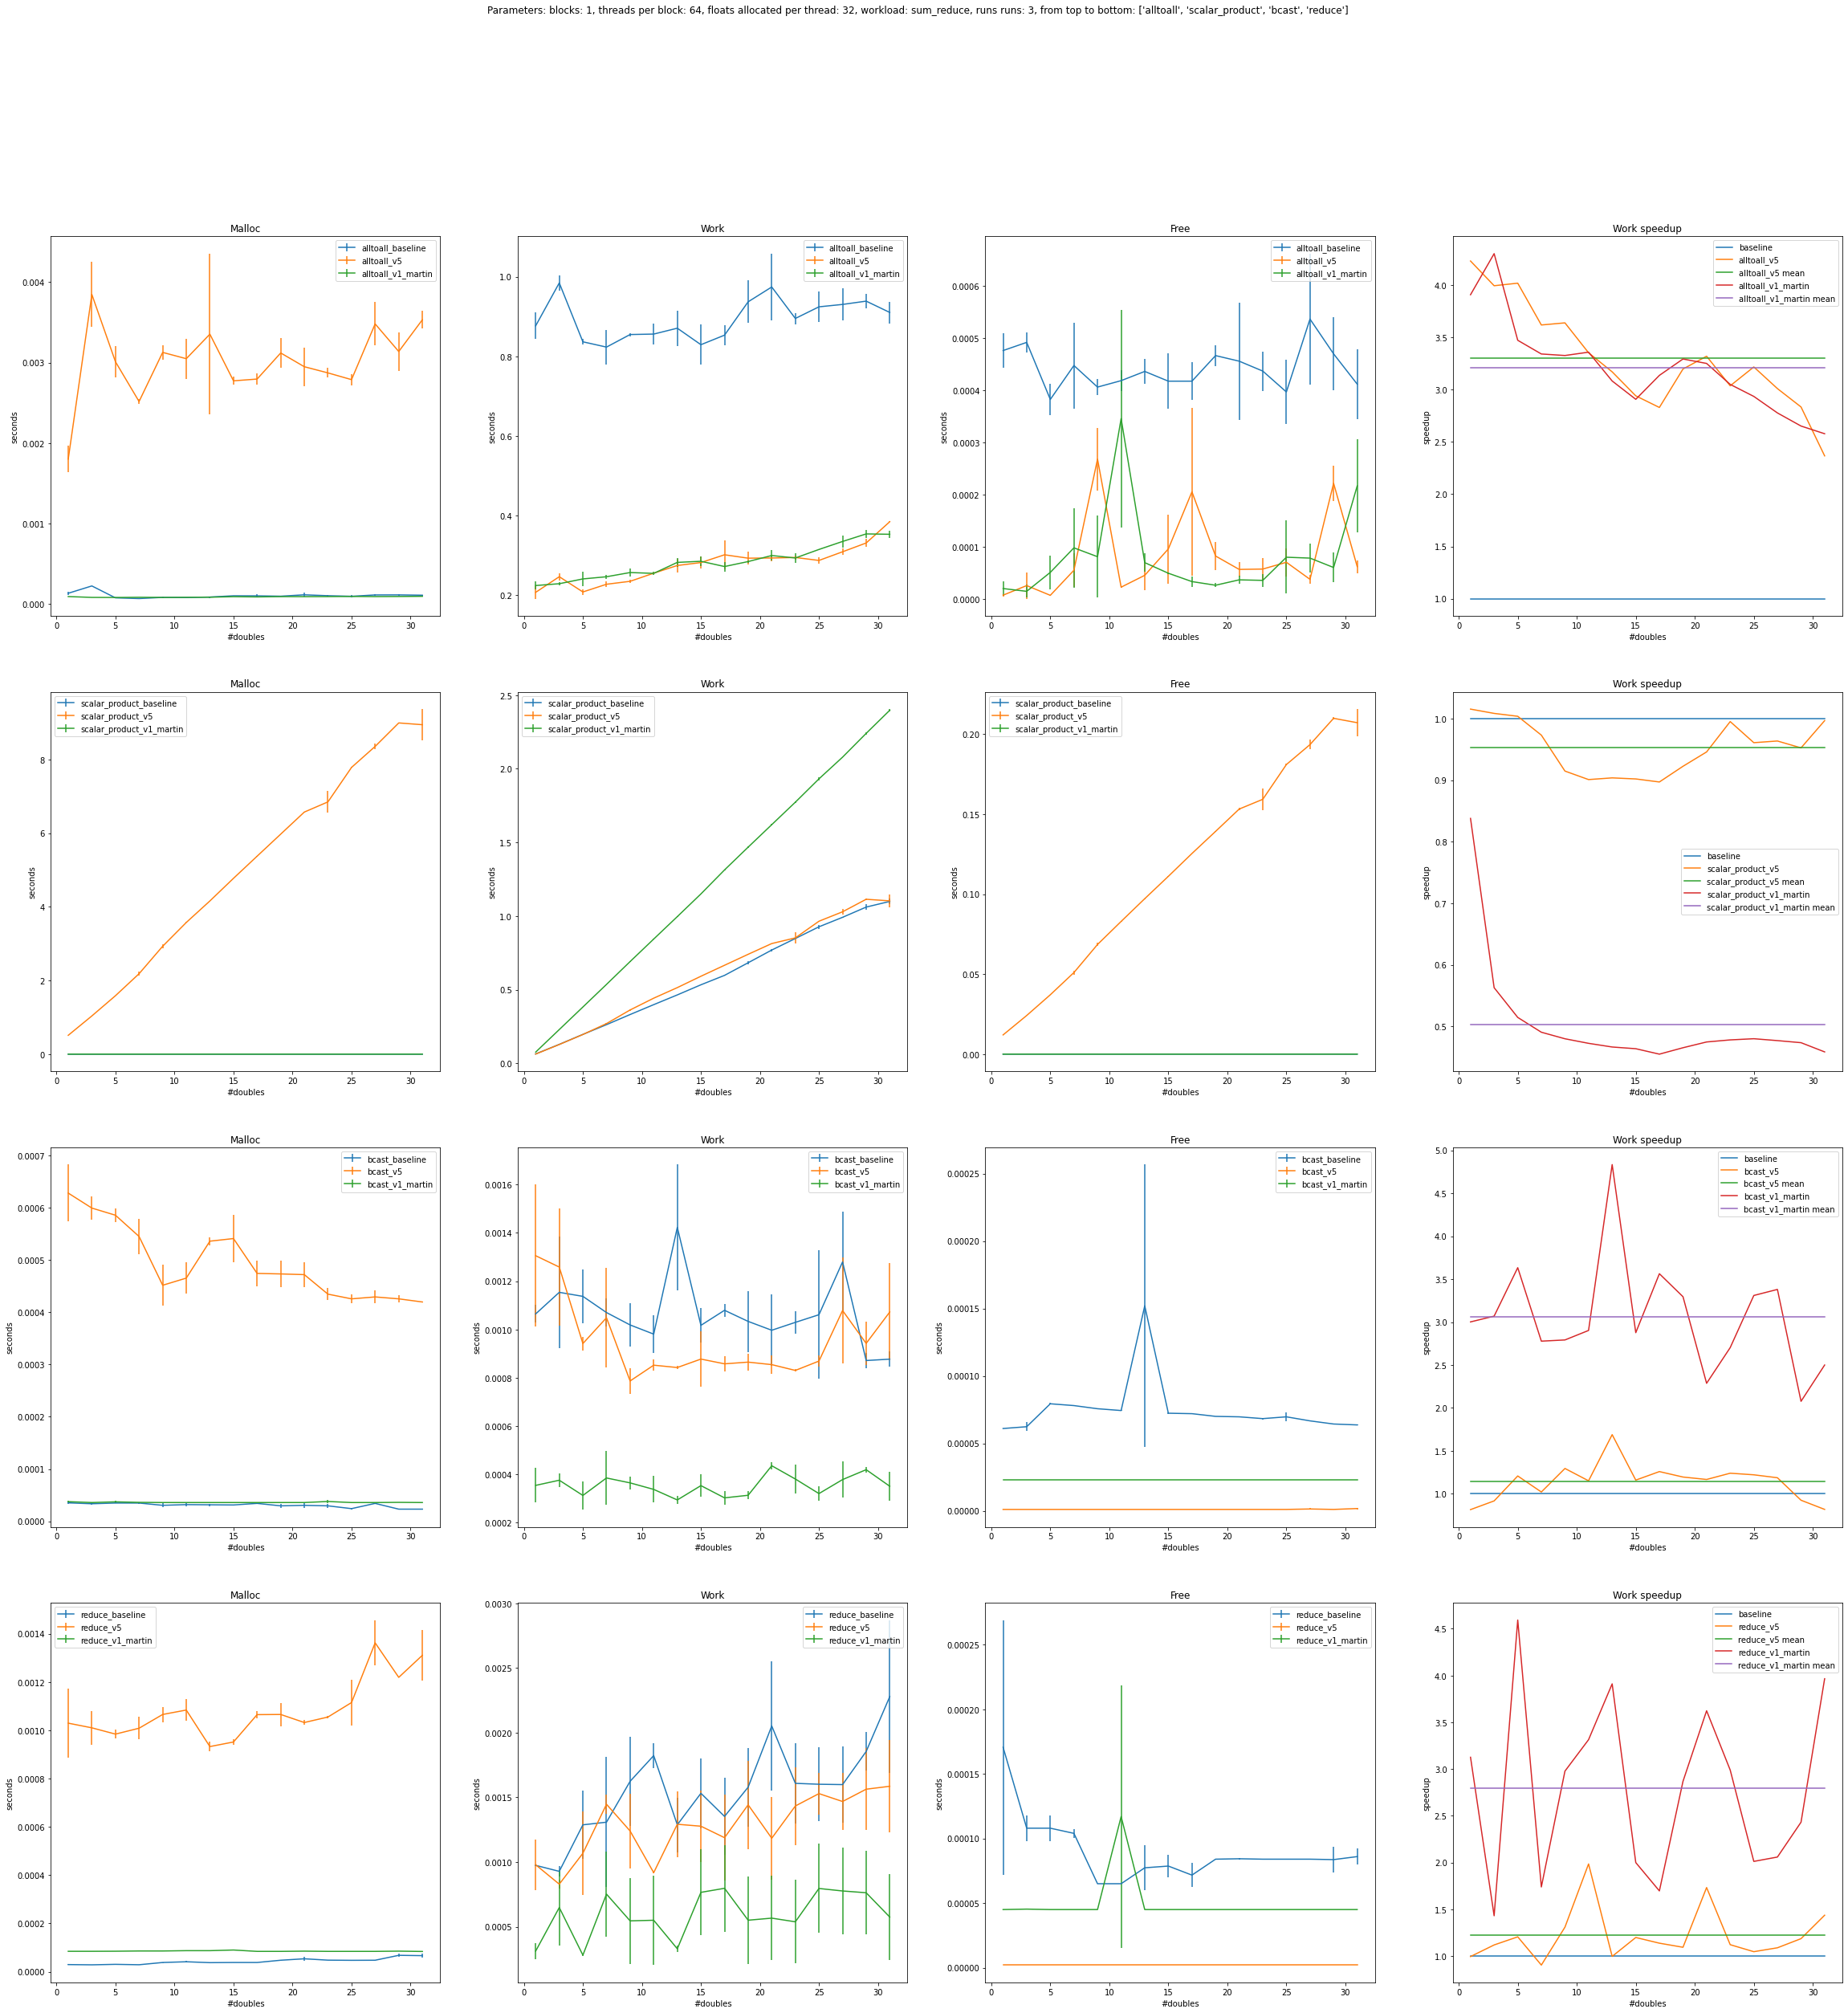

In [22]:
# parameters
n_runs = 3
n_blocks = 1
n_threads_per_block = 64
n_doubles = 32
benchmarks = ["alltoall", "scalar_product", "bcast", "reduce"]
malloc_versions = dict({0:"_baseline", 1:"_v1_flo", 2:"_v2", 3:"_v3", 4:"_v4", 5:"_v5", 6:"_v1_martin"})
versions_to_run = [0, 5, 6]
binaries = [[x+malloc_versions[y] for y in versions_to_run] for x in benchmarks]


plt.rcParams['figure.figsize'] = [40, 10*len(benchmarks)]
fig, axs = plt.subplots(len(benchmarks), 4)

if len(benchmarks) == 1:
    axs = [axs]

for b in benchmarks:
    for v in versions_to_run:
        compile_benchmark(b, v, malloc_versions)

print("Compiling finished")

floats = list(range(1, n_doubles, 2))
mean_results = []
std_results = []

for wl in tqdm(binaries):
    resm = []
    ress = []
    for malloc_v in tqdm(wl):
        mean_results_tmp = []
        std_results_tmp = []
        for n_floats_ in tqdm(floats):
            mean, std = get_mean_std_individual_workloads(n_blocks, n_threads_per_block,n_runs, n_floats_, malloc_v)
            mean_results_tmp.append(mean)
            std_results_tmp.append(std)
        resm.append([list(x) for x in zip(*mean_results_tmp)])
        ress.append([list(x) for x in zip(*std_results_tmp)])
    mean_results.append(resm)
    std_results.append(ress)

fig.suptitle("Parameters:" \
          + " blocks: " + str(n_blocks)\
          + ", threads per block: " + str(n_threads_per_block)\
          + ", floats allocated per thread: " + str(n_doubles)\
          + ", workload: sum_reduce"\
          + ", runs runs: " + str(n_runs)\
          + ", from top to bottom: " + str(benchmarks))

work = ["Malloc", "Work", "Free"]

for b in range(len(benchmarks)):
    for j in range(len(work)):
        axs[b][j].set_title(work[j])
        for i in range(len(versions_to_run)):
            axs[b][j].errorbar(floats, mean_results[b][i][j], std_results[b][i][j], label=binaries[b][i])
        axs[b][j].legend()
        axs[b][j].set_xlabel("#doubles")
        axs[b][j].set_ylabel("seconds")

    axs[b][3].set_title("Work speedup")
    axs[b][3].plot(floats, [1 for x in floats], label="baseline")
    for j in range(1, len(versions_to_run)):
        speedup = np.asarray(mean_results[b][0][1])/np.asarray(mean_results[b][j][1])
        axs[b][3].plot(floats, speedup, label=binaries[b][j])
        axs[b][3].plot(floats, [np.mean(speedup) for x in floats], label=binaries[b][j]+" mean")
    axs[b][3].legend()
    axs[b][3].set_xlabel("#doubles")
    axs[b][3].set_ylabel("speedup")

plt.show()
